In [ ]:
!pip install pyro-ppl
!pip install causal-learn

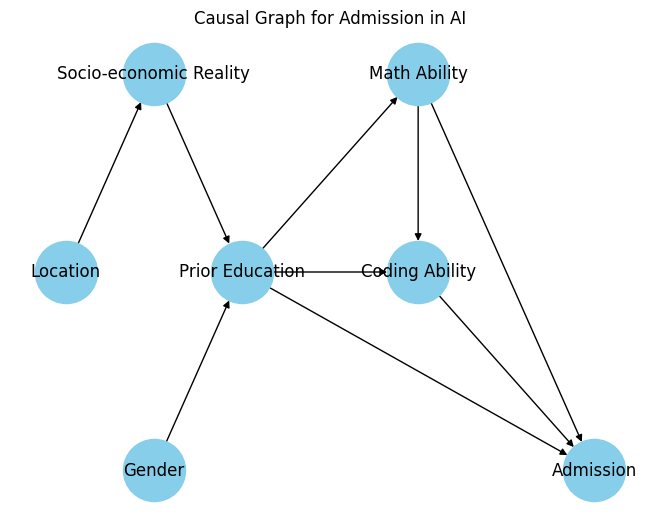

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

causal_graph = nx.DiGraph()

causal_graph.add_edges_from([
    ('Location', 'Socio-economic Reality'),
    ('Socio-economic Reality', 'Prior Education'),
    ('Prior Education', 'Math Ability'),
    ('Prior Education', 'Coding Ability'),
    ('Gender', 'Prior Education'),
    ('Math Ability', 'Admission'),
    ('Coding Ability', 'Admission'),
    ('Math Ability', 'Coding Ability'),
    ('Prior Education', 'Admission'),

])

# Specify positions for the nodes
pos = {
    'Location': (0, 0),
    'Socio-economic Reality': (1, 1),
    'Prior Education': (2, 0),
    'Math Ability': (4, 1),
    'Coding Ability': (4, 0),
    'Gender': (1, -1),
    'Admission': (6, -1)
}

# Plot the causal graph
nx.draw(causal_graph, pos,node_size=2000, node_color="skyblue",with_labels=True)
plt.title("Causal Graph for Admission in AI")
plt.show()



In [ ]:
!pip install pyro-ppl
!pip install causal-learn

In [17]:
import pyro
import pyro.distributions as dist
import torch
import pandas as pd

pyro.set_rng_seed(101)  # Setting a random seed for reproducibility

In [57]:
import pyro
import pyro.distributions as dist
from torch import tensor


def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
def causal_model():
    # Variables and their distributions
    # Independent variables
    gender = pyro.sample('gender', dist.Bernoulli(0.6))
    location = pyro.sample('location', dist.Categorical(torch.tensor([0.7, 0.3])))

    # Variables dependent on others
    # Variable Socio_economic reality depends on location
    socio_economic_reality_probs = {
        0: torch.tensor([0.7, 0.2, 0.1]),
        1: torch.tensor([0.2, 0.4, 0.4])
    }
    socio_economic_reality = pyro.sample('socio_economic_reality', dist.Categorical(socio_economic_reality_probs[location.item()]))

    # Use a normal distribution for prior_education_level
    prior_education_probs = {
      (0, 0): torch.tensor([0.6, 0.3, 0.1]),
      (0, 1): torch.tensor([0.4, 0.5, 0.1]),
      (0, 2): torch.tensor([0.2 ,0.6, 0.2]),
      (1, 0): torch.tensor([0.3, 0.5, 0.2]),
      (1, 1): torch.tensor([0.1, 0.2, 0.7]),
      (1, 2): torch.tensor([0.1, 0.4, 0.4]),

    }
    prior_education_level = pyro.sample('prior_education_level', dist.Categorical(prior_education_probs[(gender.item(), socio_economic_reality.item())]))


    # Use a normal distribution for mathematics_ability and coding_ability
    mathematics_ability = pyro.sample("mathematics_ability", dist.Normal(0.9 * prior_education_level , 0.1))
    coding_ability = pyro.sample('coding_ability', dist.Normal(0.7 * mathematics_ability, 0.1))

    # Apply sigmoid to transform the sampled values to valid probabilities
    mathematics_ability = sigmoid(mathematics_ability)
    coding_ability = sigmoid(coding_ability)
    # Admission probabilities
    admission_probs = 0.6 * mathematics_ability + 0.4 * coding_ability
    if prior_education_level.item() == 2 and admission_probs >= 0.7:
      admission_probabilty = torch.tensor([0.2 , 0.8])
    else :
      admission_probabilty = torch.tensor([0.9, 0.1])



    admission = pyro.sample('Admission', dist.Categorical(admission_probabilty))

    return {
        'location': location,
        'socio_economic_reality': socio_economic_reality,
        'gender': gender,
        'prior_education_level': prior_education_level,
        'mathematics_ability': mathematics_ability,
        'coding_ability': coding_ability,
        'Admission': admission
    }


In [61]:
types = {'mathematics_ability':float ,'coding_ability':float ,'gender':int ,'location':int , 'socio_economic_reality':int , 'prior_education_level':int ,'Admission':int}

In [62]:
def generate_data(num_samples):
    data = []
    for _ in range(num_samples):
        sample = causal_model()
        data.append(sample)
    return pd.DataFrame(data)

# Generate a synthetic dataset
synthetic_data = generate_data(10000)  # Feel free to change the number of samples
synthetic_data =synthetic_data.astype(types)
# Display the first few rows of the generated data
synthetic_data.head(20)

,location,socio_economic_reality,gender,prior_education_level,mathematics_ability,coding_ability,Admission
0,0,0,0,0,0.534168,0.524686,0
1,0,0,1,1,0.699685,0.667590,0
2,0,0,0,2,0.844899,0.750184,1
3,1,1,1,2,0.826989,0.784698,0
4,0,0,0,0,0.540919,0.504937,0
5,1,1,1,2,0.853761,0.783869,1
6,0,0,1,2,0.841947,0.777551,1
7,0,0,0,1,0.699416,0.635531,0
8,1,0,0,0,0.456184,0.449832,1
9,0,1,1,2,0.827375,0.726313,0


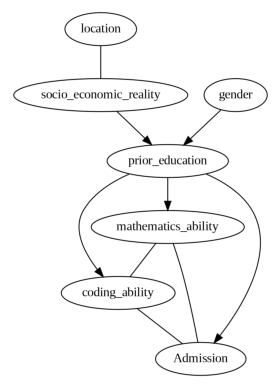

In [64]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(synthetic_data,node_names=['location','socio_economic_reality','gender' , 'prior_education', 'mathematics_ability' ,'coding_ability', 'Admission'])

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()


# or save the graph
pyd.write_png('simple_test.png')

